In [1]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

## Image extraction

In [7]:
# LUNA_mask_extraction.py
subset = "subset0"
file_list = os.listdir(f"./LUNA16/{subset}")
file_list = list(map(lambda file : f"./LUNA16/{subset}/" + file, file_list))

def make_mask(center, diam, z, width, height, spacing, origin):
    '''
        Center : centers of circles px -- list of coordinates x,y,z
        diam : diameters of circles px -- diameter
        widthXheight : pixel dim of image
        spacing = mm/px conversion rate np array x,y,z
        origin = x,y,z mm np.array
        z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height, width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center - origin)/spacing
    v_diam = int(diam/spacing[0] + 1)
    v_xmin = np.max([0, int(v_center[0]-v_diam) - 1])
    v_xmax = np.min([width-1, int(v_center[0]+v_diam) + 1])
    v_ymin = np.max([0, int(v_center[1]-v_diam) - 1]) 
    v_ymax = np.min([height-1, int(v_center[1]+v_diam) + 1])

    v_xrange = range(v_xmin, v_xmax+1)
    v_yrange = range(v_ymin, v_ymax+1)

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center - np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y-origin[1]) / spacing[1]), int((p_x-origin[0]) / spacing[0])] = 1.0
    return(mask, [v_xmin, v_xmax, v_ymin, v_ymax])

def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)
        
def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

if __name__ == "__main__":
    df_node = pd.read_csv("./LUNA16/annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    df_roi = pd.read_csv("./ROI_coor3.csv")
    df_roi_cur = dict()
    
    print(f"TRÍCH XUẤT ẢNH VÀ TỌA ĐỘ TỪ FILE .raw VÀ FILE .mhd TỪ {subset}")
    for fcount, img_file in enumerate(tqdm(file_list)):
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
        if len(mini_df) > 0:       # some files may not have a nodule--skipping those
            itk_img = sitk.ReadImage(img_file) # read .mhd file
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            num_z, height, width = img_array.shape
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            
            for node_idx, cur_row in mini_df.iterrows():       
                node_x = cur_row["coordX"]
                node_y = cur_row["coordY"]
                node_z = cur_row["coordZ"]
                diam = cur_row["diameter_mm"]
                
                imgs = np.ndarray([5, height, width], dtype=np.float32)
                masks = np.ndarray([5, height, width], dtype=np.uint8)
                center = np.array([node_x, node_y, node_z])   # nodule center
                v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            
                for i, i_z in enumerate(np.arange(int(v_center[2])-2, int(v_center[2])+3).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                    mask, roi = make_mask(center, diam, i_z*spacing[2]+origin[2], width, height, spacing, origin)
                    if i == 2:
                        roi_key = f"{img_file.split('/')[-1].rsplit('.', 1)[0]}_{fcount}_{node_idx}"
                        df_roi_cur.update({roi_key: roi})
                    imgs[i] = img_array[i_z]
                    masks[i] = mask
                img_name = f"{img_file.split('/')[-1].rsplit('.', 1)[0]}_{fcount}_{node_idx}.npy"
                mask_name = f"{img_file.split('/')[-1].rsplit('.', 1)[0]}_{fcount}_{node_idx}.npy"
                
                if os.path.isdir(f"./LUNA16/images/{subset}") is False and os.path.isdir(f"./LUNA16/masks/{subset}") is False:
                    os.mkdir(f"./LUNA16/images/{subset}")
                    os.mkdir(f"./LUNA16/masks/{subset}")
                    np.save(os.path.join(f"./LUNA16/images/{subset}", img_name), imgs)
                    np.save(os.path.join(f"./LUNA16/masks/{subset}", mask_name), masks)
                else:
                    np.save(os.path.join(f"./LUNA16/images/{subset}", img_name), imgs)
                    np.save(os.path.join(f"./LUNA16/masks/{subset}", mask_name), masks)
         
    df_temp = pd.DataFrame.from_dict(df_roi_cur, columns=["x_min", "x_max", "y_min", "y_max"], orient='index')
    df_temp["ID"] = list(df_roi_cur.keys())
    df_temp = df_temp.reset_index(drop=True)
    df_roi = pd.concat([df_roi, df_temp])
    df_roi.to_csv("ROI_coor3.csv", index=False)
    
    img_files = os.listdir(f"./LUNA16/images/{subset}")
    for img_file in tqdm(img_files):
        imgs = np.load(f"./LUNA16/images/{subset}/{img_file}")
        img = normalize(imgs[2])
        img_grey = img * 255
        img_rgb = np.stack((img_grey,)*3, -1)
        cv2.imwrite(f"./preprocessed_img2/{img_file.rsplit('.', 1)[0]}.png", img_rgb)

TRÍCH XUẤT ẢNH VÀ TỌA ĐỘ TỪ FILE .raw VÀ FILE .mhd TỪ subset0


100%|██████████| 112/112 [00:04<00:00, 25.39it/s]


In [21]:
import os
import pandas as pd

def find_missing_ids(folder_path, csv_file):
    """
    Tìm các ID trong file CSV không tương ứng với tên file trong thư mục.

    Args:
        folder_path (str): Đường dẫn đến thư mục chứa hình ảnh.
        csv_file (str): Đường dẫn đến file CSV chứa danh sách ID.

    Returns:
        list: Danh sách các ID không tìm thấy.
    """

    # Lấy danh sách tên file (không có phần mở rộng)
    file_names = [os.path.splitext(file)[0] for file in os.listdir(folder_path)]

    # Đọc dataframe từ file CSV
    df = pd.read_csv(csv_file)
    ids = df['ID'].tolist()  # Giả sử cột ID có tên là 'ID'

    # Tìm các ID không có trong danh sách tên file
    missing_ids = [id for id in ids if id not in file_names]

    return missing_ids

# Thay thế bằng đường dẫn thực tế
folder_path = './preprocessed_img2'
csv_file = './ROI_coor3.csv'

missing_ids = find_missing_ids(folder_path, csv_file)

if missing_ids:
    print("Các ID không tìm thấy:", missing_ids)
else:
    print("Tất cả các ID đều tồn tại trong thư mục.")

Các ID không tìm thấy: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249_0_8']


In [24]:
df = pd.read_csv("./LUNA16/annotations.csv")
df.describe()["diameter_mm"]

count    1186.000000
mean        8.306527
std         4.762033
min         3.253443
25%         5.107177
50%         6.433600
75%         9.696301
max        32.270030
Name: diameter_mm, dtype: float64

In [8]:
import csv

def count_unique_ids(filename, label=None):
  """Đếm số lượng ID duy nhất trong một file CSV.

  Args:
    filename: Tên file CSV.
    label: Nếu có, chỉ đếm các dòng có cột nhãn bằng label.

  Returns:
    Số lượng ID duy nhất.
  """
  unique_ids = set()
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    # Giả sử cột ID là cột đầu tiên, cột nhãn là cột thứ hai
    for row in reader:
      if label is None or row[4] == str(label):
        unique_ids.add(row[0])
  return len(unique_ids)

def find_missing_ids(annotation_file, candidate_file):
  """Tìm các ID có trong annotation nhưng không có trong candidate.

  Args:
    annotation_file: Tên file annotation.
    candidate_file: Tên file candidate.

  Returns:
    Danh sách các ID không có trong candidate.
  """
  annotation_ids = set()
  candidate_ids = set()

  with open(annotation_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    # Giả sử cột ID là cột đầu tiên
    for row in reader:
      annotation_ids.add(row[0])

  with open(candidate_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    # Giả sử cột ID là cột đầu tiên
    for row in reader:
      candidate_ids.add(row[0])

  return annotation_ids - candidate_ids

# Thay thế 'annotation.csv' và 'candidate.csv' bằng đường dẫn đến file của bạn
annotation_file = './LUNA16/annotations.csv'
candidate_file = './LUNA16/candidates_V2/candidates_V2.csv'

# Đếm số lượng ID duy nhất trong annotation
num_annotation_ids = count_unique_ids(annotation_file)
print(f"Số lượng ID riêng biệt trong annotation.csv: {num_annotation_ids}")

# Đếm số lượng ID có nhãn là 1 trong candidate
num_candidate_ids_label_1 = count_unique_ids(candidate_file, label=1)
print(f"Số lượng ID riêng biệt có nhãn là 1 trong candidate.csv: {num_candidate_ids_label_1}")

# Tìm các ID có trong annotation nhưng không có trong candidate
missing_ids = find_missing_ids(annotation_file, candidate_file)
print("Các ID có trong annotation nhưng không có trong candidate:", missing_ids)

Số lượng ID riêng biệt trong annotation.csv: 602
Số lượng ID riêng biệt có nhãn là 1 trong candidate.csv: 600
Các ID có trong annotation nhưng không có trong candidate: set()


In [13]:
df = pd.read_csv(annotation_file)
num_unique_ids = df['seriesuid'].nunique()
print(num_unique_ids)

601


In [20]:
df = pd.read_csv(candidate_file)
df_class_1 = df[df['class'] == 1]
num_unique_ids_class_1 = df_class_1['seriesuid'].nunique()
print(num_unique_ids_class_1)

600


image 0


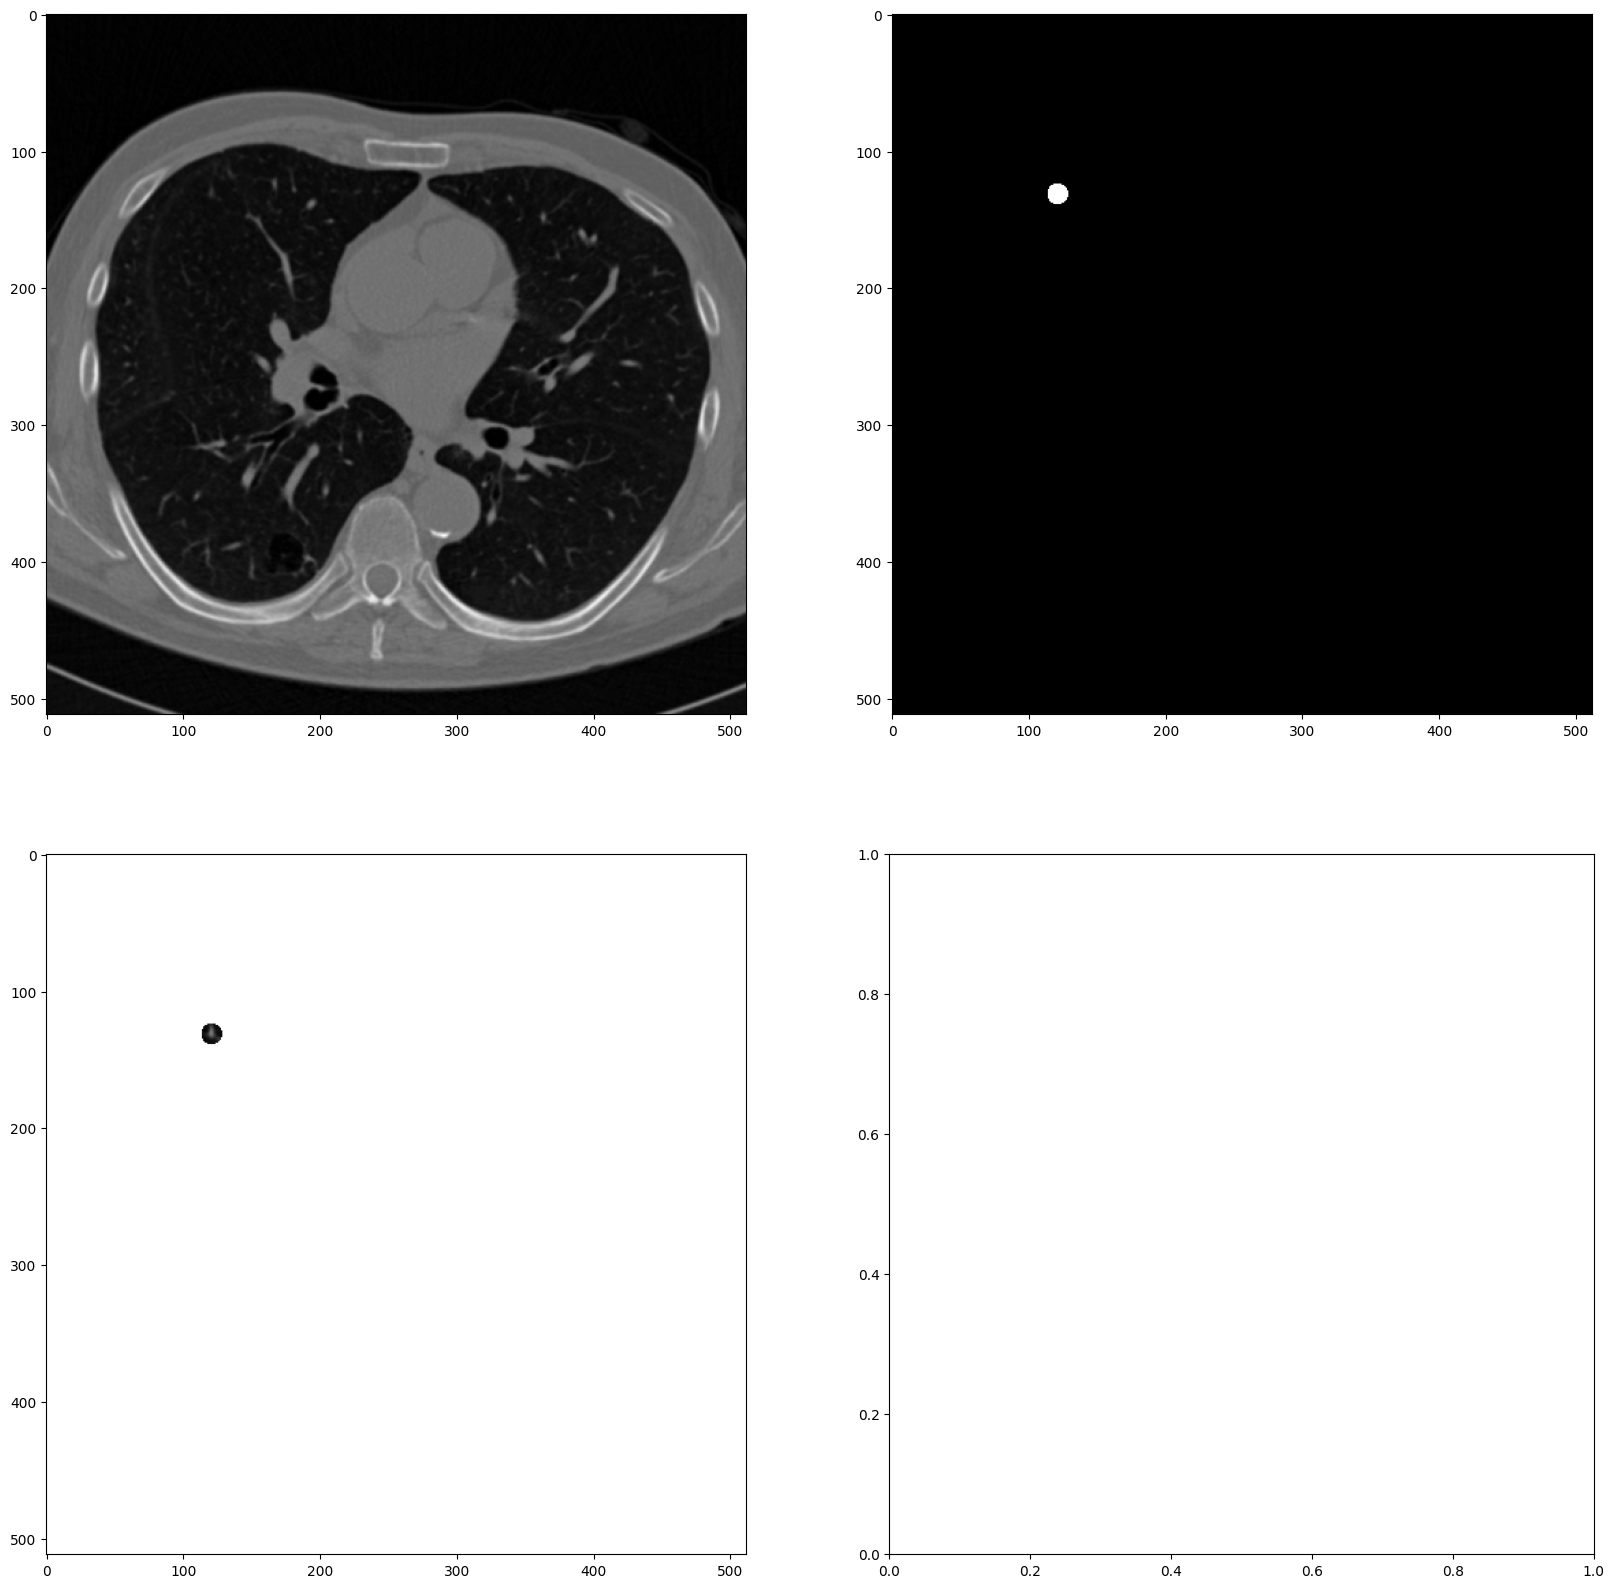

image 1


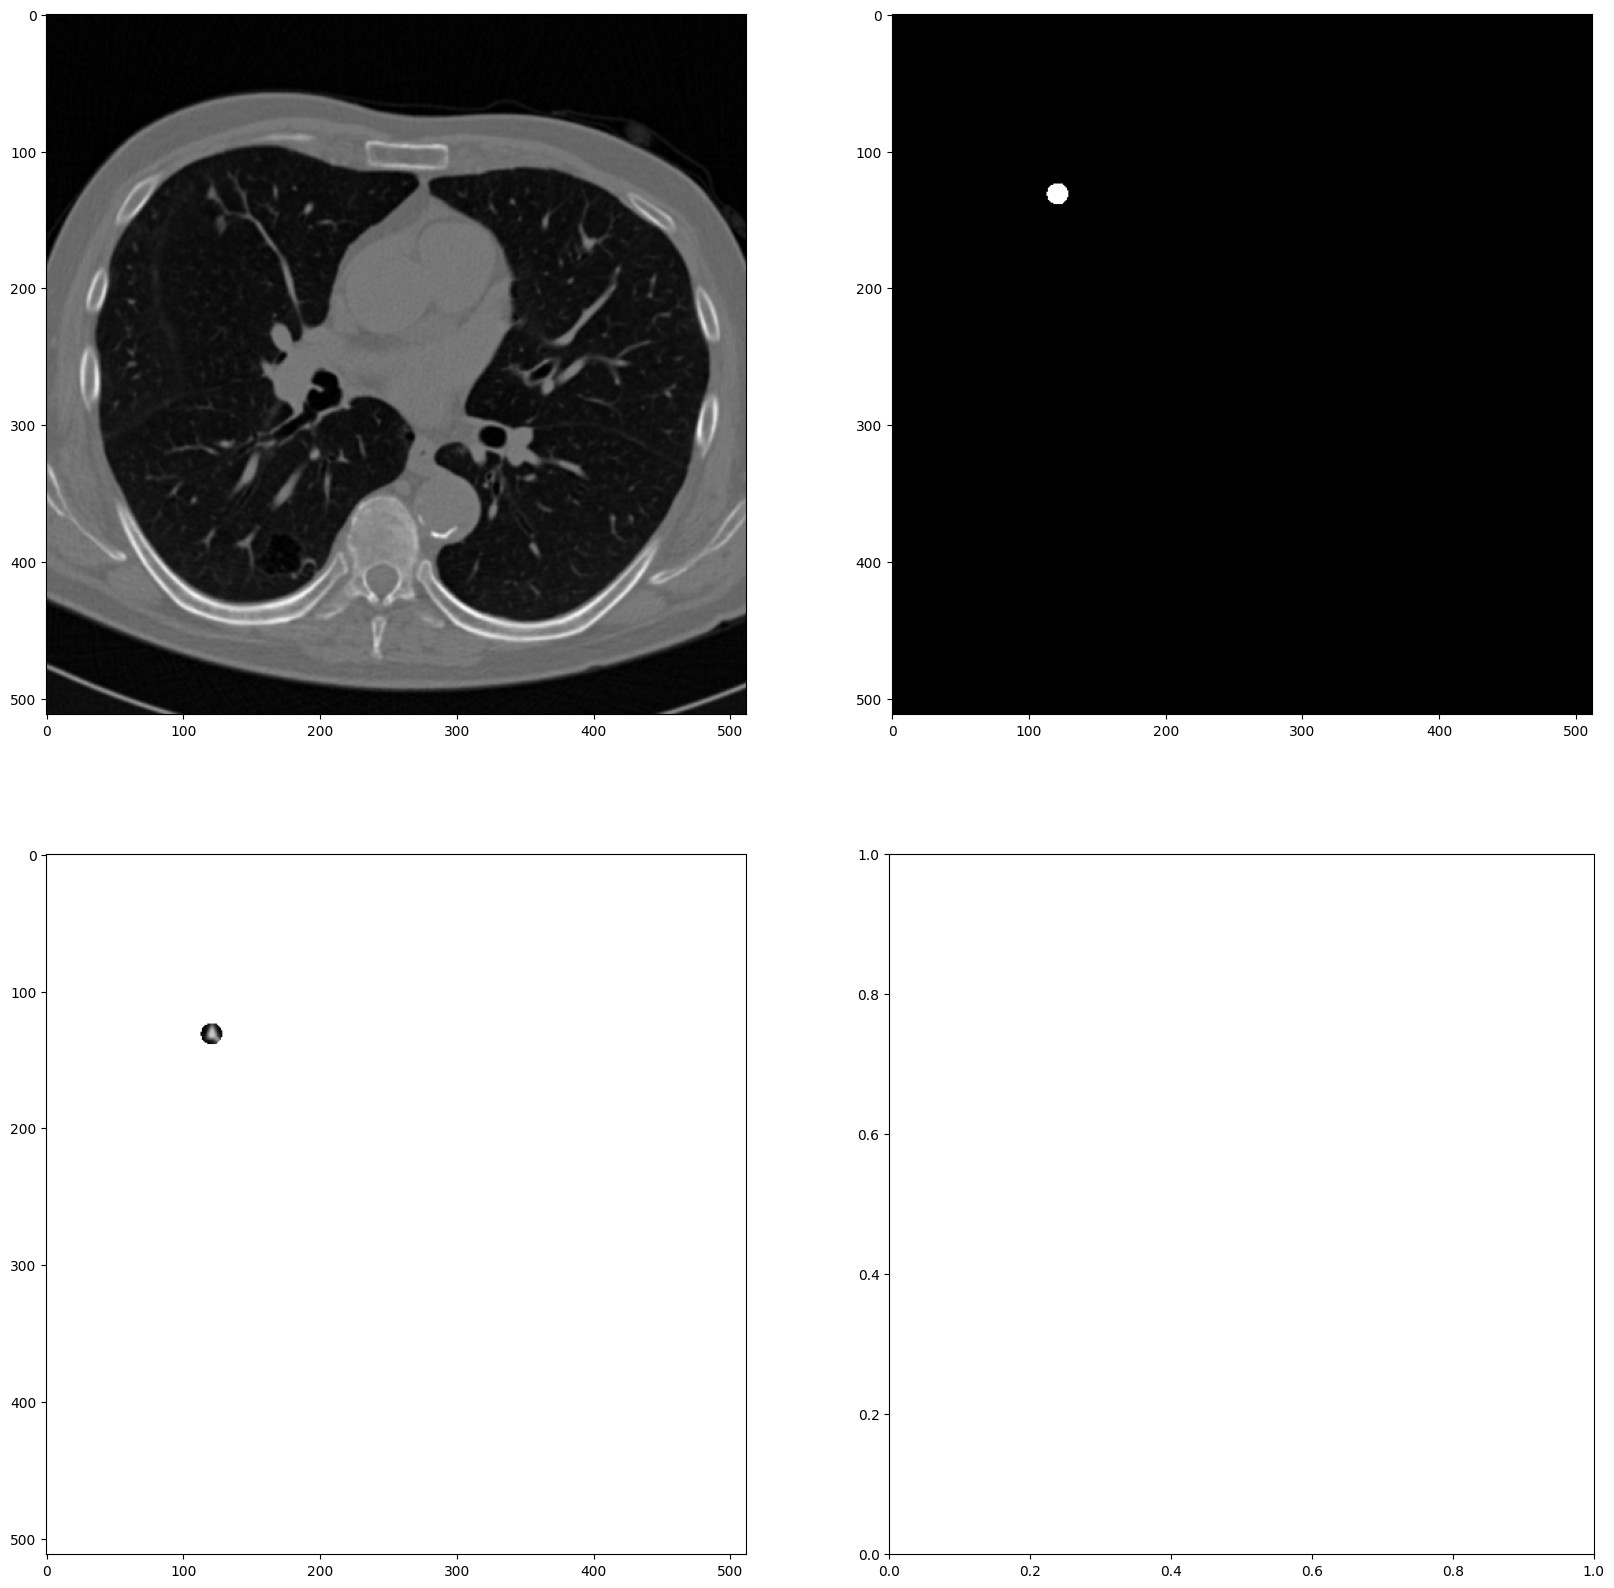

image 2


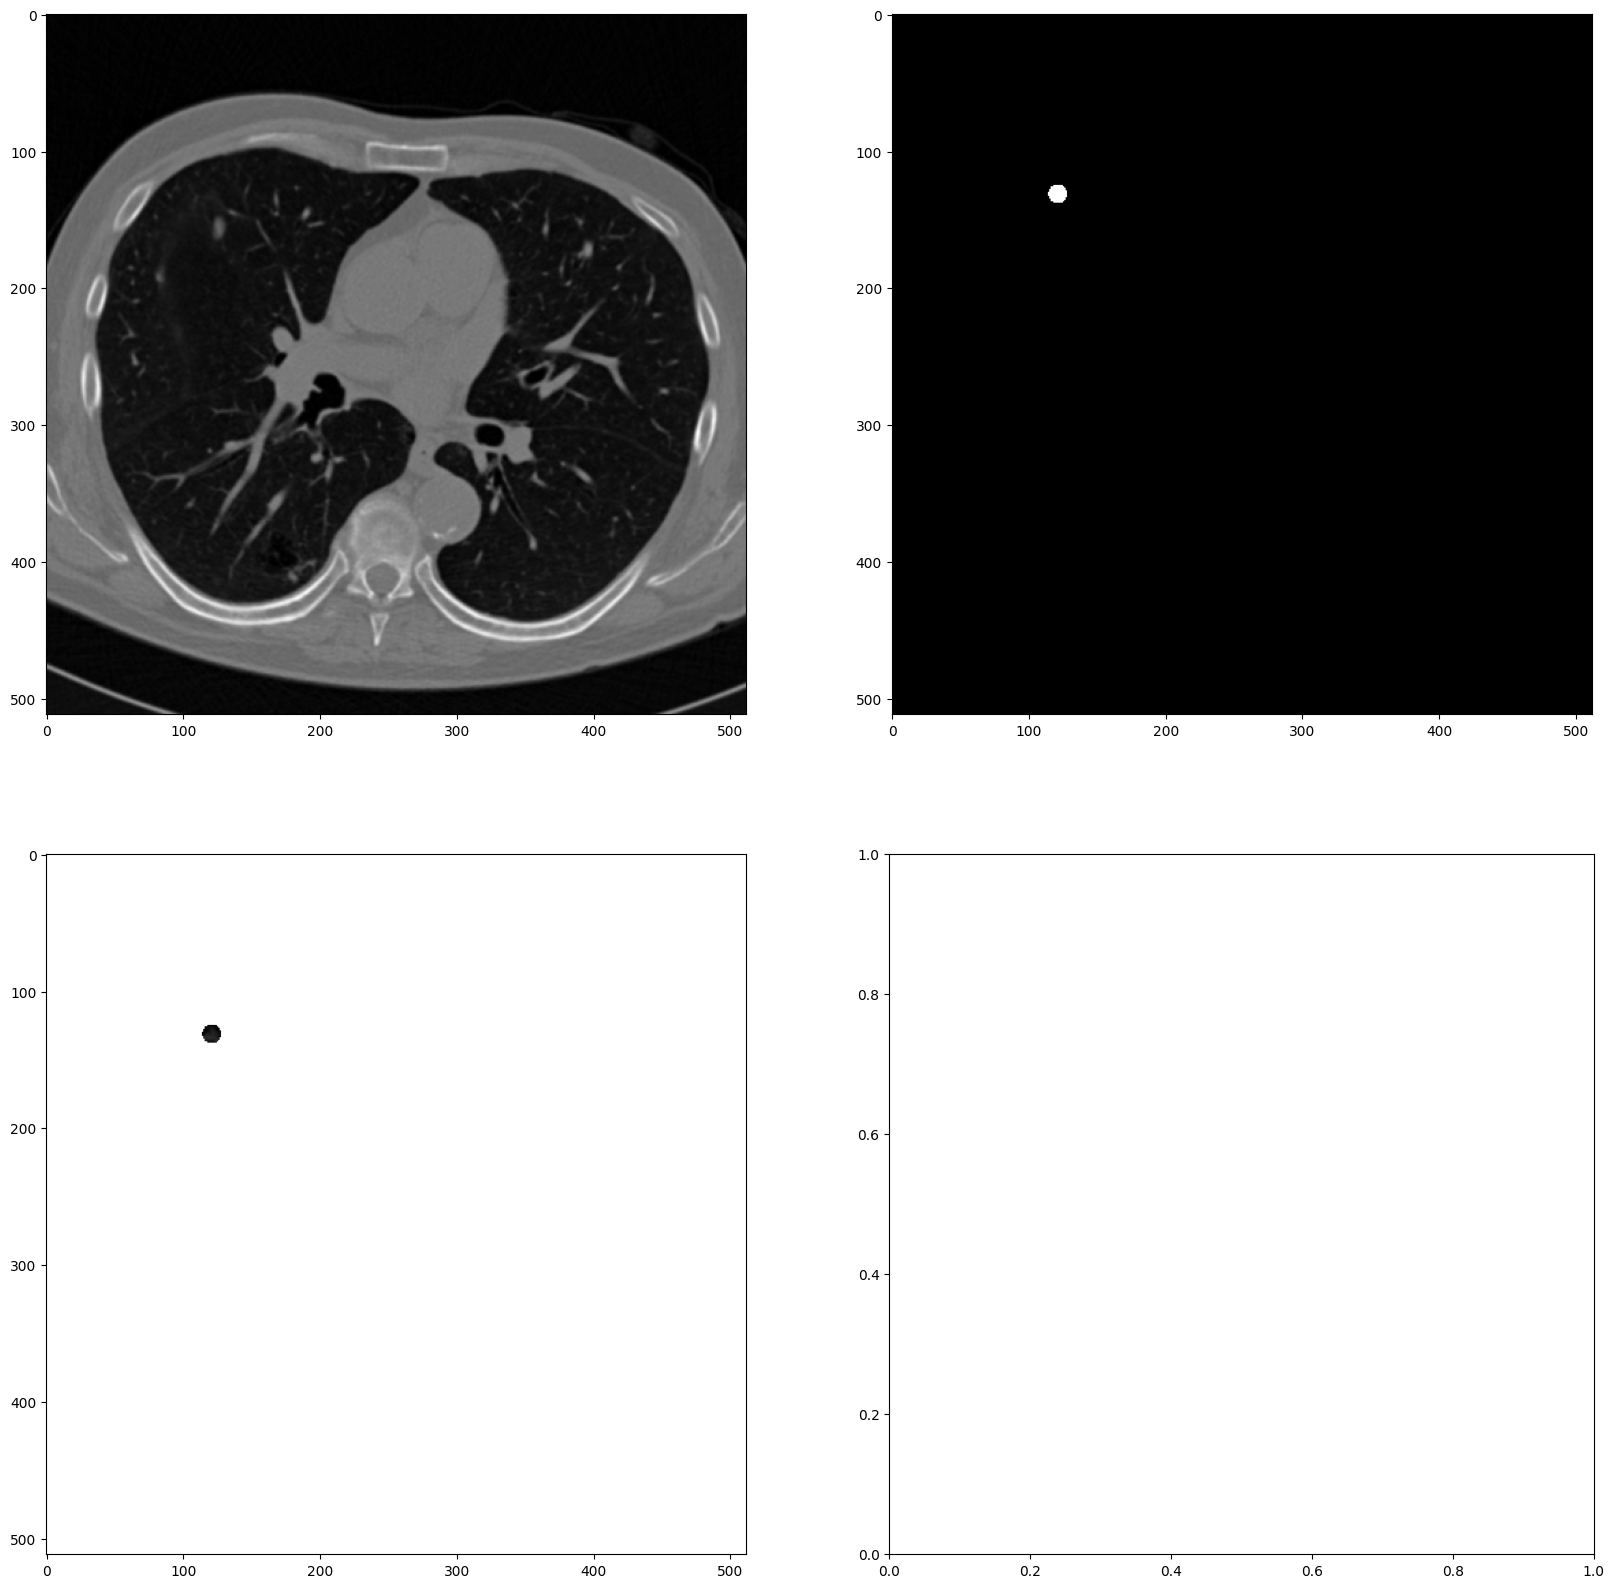

In [43]:
import matplotlib.pyplot as plt

id = "1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795_82_542.npy"
imgs = np.load(f"./LUNA16/images/{id}")
masks = np.load(f"./LUNA16/masks/{id}")
for i in range(len(imgs)):
    print("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[20,20])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()

In [106]:
file_name = "./LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221.mhd"
itkimage = sitk.ReadImage(file_name)
ct_scan = sitk.GetArrayFromImage(itkimage)
origin = np.array(list(reversed(itkimage.GetOrigin())))
spacing = np.array(list(reversed(itkimage.GetSpacing())))
canter = np.array([116.8024039,-1.291850522,-197.5054168])
diam = 4.666322736



In [125]:
nodules_center_voxel = np.rint(np.absolute(center-origin)/spacing)
width_half = int(diam / spacing[1] / 2 + 0.999)
i_x, i_y, i_z = nodules_center_voxel
x1, x2, y1, y2 = int(i_x-width_half), int(i_x+width_half), int(i_y-width_half), int(i_y+width_half)
print(x1, x2, y1, y2)

254 262 145 153


In [6]:
ids = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860_0_0"
img_rgb = cv2.imread(f"./preprocessed_img/{ids}.png")
temp = f"images_{ids}".split('_', 1)[-1]
df_roi = pd.read_csv("./ROI_coor2.csv")
a = df_roi[df_roi["ID"] == f"{temp}"]
print(a)
x_min, x_max, y_min, y_max = a["x_min"].iloc[0], a["x_max"].iloc[0], a["y_min"].iloc[0], a["y_max"].iloc[0]
ct_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# ct_img = cv2.medianBlur(ct_img, 9)
cv2.rectangle(ct_img, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=2)
# cv2.rectangle(ct_img, (x1 + 2, y1 + 2), (x2 + 2, y2 + 2), color=(255,0,0), thickness=2)
cv2.imshow("lalala", ct_img)
cv2.waitKey(0)

     x_min  x_max  y_min  y_max  \
944     34     54    201    221   

                                                    ID  
944  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  


-1

## Image preprocessing

In [21]:
df_roi = pd.read_csv("./ROI_coor3.csv")
df_roi = df_roi[(df_roi['x_min'] >= 0) & (df_roi['x_max'] >= 0) & (df_roi['y_min'] >= 0) & (df_roi['y_max'] >= 0)]
df_roi.info()
df_roi.to_csv("ROI_coor3.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1162 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x_min   1162 non-null   int64 
 1   x_max   1162 non-null   int64 
 2   y_min   1162 non-null   int64 
 3   y_max   1162 non-null   int64 
 4   ID      1162 non-null   object
dtypes: int64(4), object(1)
memory usage: 54.5+ KB


In [22]:
df = pd.read_csv("./ROI_coor3.csv")
ids = df["ID"].to_numpy()

file_list = os.listdir("./preprocessed_img2")
for i in tqdm(file_list):
    file_name = i.rsplit(".", 1)[0]
    if file_name not in ids:
        os.remove(f"./preprocessed_img2/{i}")

100%|██████████| 1186/1186 [00:00<00:00, 12423.90it/s]


In [2]:
ct_img = cv2.imread("./preprocessed_img/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860_0_0.png")
ct_img = cv2.cvtColor(ct_img, cv2.COLOR_BGR2GRAY)
ct_img = cv2.medianBlur(ct_img, 9)
cv2.imshow("lalala", ct_img)
cv2.waitKey(0)

(512, 512, 3)

In [9]:
def yolo_format_calculate(x_min, x_max, y_min, y_max, width, height):
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_center = x_min + (box_width/2)
    y_center = y_min + (box_height/2)

    return x_center/width, y_center/height, box_width/width, box_height/height

In [8]:
df_roi = pd.read_csv("./ROI_coor2.csv")
for idx, row in df_roi.iterrows():
    x_min = row["x_min"].iloc[0]
    x_max = row["x_max"].iloc[0]
    y_min = row["y_min"].iloc[0]
    y_max = row["y_max"].iloc[0]
    roi_id = row["ID"].iloc[0]
    
    x_center, y_center, box_w, box_h = yolo_format_calculate(x_min, x_max, y_min, x_max)
    
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x_min   1162 non-null   int64 
 1   x_max   1162 non-null   int64 
 2   y_min   1162 non-null   int64 
 3   y_max   1162 non-null   int64 
 4   ID      1162 non-null   object
dtypes: int64(4), object(1)
memory usage: 45.5+ KB
